### Rishi Shah 
### Sneh Shah

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy as sps
import sys
import time
import pandas as pd
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from numpy import linalg
from scipy import linalg, stats
from sympy import *
from skimage import io
import collections 
from PIL import Image
from sklearn import svm

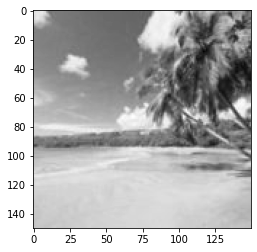

In [28]:
#load in image 
image = '/content/drive/MyDrive/beach.jpg'
img = io.imread(image)
grayImg = np.dot(img[...,:3], [0.21, 0.72, 0.07])
plt.imshow(grayImg, cmap=plt.get_cmap("gray"))

In [29]:
#split image in half 
height, width, dim = img.shape

cutoff = width // 2
s1 = img[:, :cutoff]
s2 = img[:, cutoff:]



(150, 75, 3)
(11250, 3)


array([[206, 224, 246],
       [204, 221, 241],
       [211, 224, 243],
       ...,
       [228, 212, 187],
       [228, 212, 187],
       [228, 212, 187]], dtype=uint8)

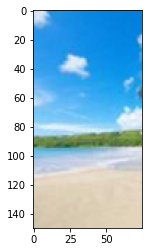

In [30]:
#reshape left side of image 
print(s1.shape)
s1_flatten = s1.reshape(-1,3)
print(s1_flatten.shape)
plt.imshow(s1_flatten.reshape(s1.shape))
#plt.imshow(s1)
s1_flatten

## 1. Basic Agent

In [ ]:
#function to return  cluster that's minimum distance (euclidian) away from point
def getCluster(arr, pixel): #takes in array of clusters and pixel rgb value as input, returns cluster center that pixel is closest to
  min = sys.maxsize
  cluster = 0
  for i in range(len(arr)): #iterate through k clusters to find where pixel belongs 
    distR = abs(pixel[0]-arr[i][0]) ** 2 
    distG = abs(pixel[1]-arr[i][1]) ** 2
    distB = abs(pixel[2]-arr[i][2]) ** 2
    euclid = (distR + distG + distB) ** (1/2)
    if (euclid<min): #keeping track of minimum 
      min = euclid
      cluster = arr[i]
  
  return cluster
  


In [ ]:
#kMeans function to train left side of image with k colors
def kMeans(data, k): #takes in left side of image as input, as well as k which represents the number of desired colors in the trained image 
  arr = []
  i = 0
  #appending cluster centers to array
  while i < k:
    randVal = np.random.randint(0,data.shape[0])
    rgbValue = (data[randVal][0],data[randVal][1],data[randVal][2])
    if rgbValue in arr:
      continue
    arr.append(rgbValue)
    i += 1
  
  print(arr)
  cond = True
  
  prevDict = {}
  currentDict = {}
  for i in range(k):
    key = i
    prevDict[i] = []
    currentDict[i] = []
  

  iterations = 0

  #running loop until iterations hit 50; also stops if cluster centers/members don't move
  while iterations < 50 and cond == True:
    #print("Iteration Number: " ,iterations)
    for i in range(k):
      currentDict[i] = []
    #fullAssignments = []
    cond = False

    #going through left side of the image and assign cluster membership
    for i in range(len(data)):
        #print("pixel number: ", i)
        pixelArr = data[i] #gives rgb array
        #print(pixel)
        pixel = (pixelArr[0], pixelArr[1], pixelArr[2])
        cluster = getCluster(arr,pixel)
        pixel = (pixelArr[0], pixelArr[1], pixelArr[2], i)

        for x in range(k):
          if (cluster == arr[x]):
            currentDict[x].append(pixel)
            if pixel not in prevDict[x]:
              cond = True
        
        

  
    #print("assignments are:", assignments)  
    #prev = assignments.copy()
    #print(prev)
    for i in range(k): 
      prevDict[i] = currentDict[i].copy()

    if cond == False:
      break
    
    count = 0
    #loop to calculate new cluster centroids
    for i in range(k):
      currArr = currentDict[i]
      totalR = 0
      totalG = 0
      totalB = 0
      for j in range(len(currArr)):
        rgbVal = currArr[j]
        totalR += rgbVal[0]
        totalG += rgbVal[1]
        totalB += rgbVal[2]

      totalR = totalR/len(currArr)
      totalG = totalG/len(currArr)
      totalB = totalB/len(currArr)

      newRGB = (totalR,totalG,totalB)
      diffR = abs(totalR - arr[i][0])
      diffG = abs(totalG - arr[i][1])
      diffB = abs(totalB - arr[i][2])
      #print("Difference: ", diffR + diffG + diffB)
      if (diffR == 0 and diffG == 0 and diffB == 0):
        count += 1
        
      arr[i] =  newRGB
      
    #loop stops if all cluster centers don't move 
    if (count == k):
      break
    iterations+=1
    #cond = False
    #print(cond)
    #print(arr)
  
  return arr, currentDict 
        

      
        

        




In [ ]:
arr, currentDict = kMeans(s1_flatten, 5)
print(arr)


[(226, 209, 189), (58, 166, 238), (15, 143, 232), (58, 171, 241), (60, 157, 226)]
Iteration Number:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


Iteration Number:  1
Iteration Number:  2
Iteration Number:  3
Iteration Number:  4
Iteration Number:  5
Iteration Number:  6
Iteration Number:  7
Iteration Number:  8
Iteration Number:  9
[(102.54285714285714, 134.69142857142856, 84.39714285714285), (102.93059263214096, 185.73465029364655, 238.562733582488), (24.422903993652472, 146.81935995768316, 231.0161332980693), (221.3023855577047, 208.9323017408124, 186.50386847195358), (194.46098104793757, 217.36733556298773, 236.97491638795987)]


In [ ]:
#function colors an image based on the output of basic agent
def colorImage(s1_flatten, currDict, arr, s1):
  s1Res = s1_flatten.copy()

  for i in range(len(currDict)):
    for j in range(len(currDict[i])):
      info = currDict[i][j]
      s1Res[info[3]] = arr[i]
      
  s1Res = s1Res.reshape(s1.shape)
  return s1Res

In [ ]:
s1Res = colorImage(s1_flatten, currentDict, arr, s1)
plt.imsave("/content/drive/MyDrive/kmeans.jpg",s1Res)
plt.imshow(s1Res)
#trained 5 color image

NameError: ignored

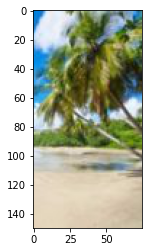

In [31]:
height, width = grayImg.shape

cutoff = width // 2
greyS1 = grayImg[:, :cutoff]
greyS2 = grayImg[:, cutoff:]
plt.imshow(s2)


In [ ]:
#function to color in right side of image using 3x3 grayscale patches 
def searchS1(gsArr, greyS1, s1Res, num): #takes in grayscale image of left side and right side, resulting trained image of left side and returns the appropriate color that pixel should be based upon similarity of grayscale patches
  minArray = []
  for i in range(num):
    minArray.append((sys.maxsize,None))
 
  movements = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(-1,-1),(-1,1),(1,-1)]

  for i in range(1,greyS1.shape[0]-1): #creating grayscale patches in left side of image 
    for j in range(1,greyS1.shape[1]-1):
      compArr = [greyS1[i][j]]
      for k in range(len(movements)):
        xVal = i + movements[k][0]
        yVal = j + movements[k][1]
        compArr.append(greyS1[xVal][yVal])

      diffArr = np.absolute(np.subtract(gsArr,compArr)) #taking difference between grayscale patches in right and left side 
      sum = np.sum(diffArr) #adding up the differences between each pixel in the 3x3 patch 

      minArray = sorted(minArray, key = lambda minArray: minArray[0], reverse = True)

      if (sum<minArray[0][0]):
        rgbVal = s1Res[i][j]
        minArray[0] = (sum, rgbVal)
  
  
  colors = []
  for i in range(num):
    colors.append((minArray[i][1][0],minArray[i][1][1],minArray[i][1][2]))
  

  occurrences = collections.Counter(colors) #looking for the color that is the mode in the 6 closest gray scale patches 

  max_value = max(occurrences.values())  # maximum value
  max_keys = [k for k, v in occurrences.items() if v == max_value] # getting all keys containing the `maximum`

  #print(minArray)
  if (len(max_keys)!=1): 
    return minArray[5][1]
  else:
    return max_keys[0]





      
      



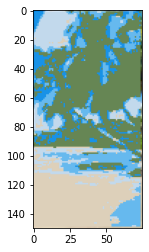

In [ ]:
def basicAgent(s1Res, greyS1, greyS2, s2, n): #basic agent for coloring in right side of image, takes in left and right side of images and returns fully colored in right-side of the image 
  movements = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(-1,-1),(-1,1),(1,-1)]
  s2Res = s2.copy()
  for i in range(1,greyS2.shape[0]-1): #creating 3x3 grayscale patch for current pixel on right side 
    for j in range(1,greyS2.shape[1]-1):
      gsArr = [greyS2[i][j]]
      for k in range(len(movements)):
        xVal = i + movements[k][0]
        yVal = j + movements[k][1]
        gsArr.append(greyS2[xVal][yVal])
      
      color = searchS1(gsArr, greyS1, s1Res, n) #finding the most similar grayscale patches and assigning current pixel a color 
      s2Res[i][j] = color
      #print(color)
      #print("pixel: ", (i,j))


  return s2Res

s2Res = basicAgent(s1Res, greyS1, greyS2, s2, 6)
plt.imshow(s2Res)

In [ ]:
plt.imsave("/content/drive/MyDrive/basicAgent.jpg",s2Res)


In [ ]:
#loss function
def lossFunction(s2Res, s2): #calculating accuracy of basic agent with loss function
  lossSum = 0
  for i in range(1,s2Res.shape[0]-1):
    for j in range(1,s2Res.shape[1]-1):
      s2RGB = s2[i][j]
      s2ResRGB = s2Res[i][j]
      diffArr = np.absolute(np.subtract(s2RGB,s2ResRGB))
      sum = np.sum(diffArr) 
      lossSum += sum
  return lossSum

print(lossFunction(s2Res,s2))

4298474.0


## 2. Bonus Basic Agent - Identifying Optimal Number of Clusters

In [ ]:
def calculateInertia(arr, currDict): #bonus: calculating inertia of 
  totalDist = 0
  for i in range(len(currDict)):
    for j in range(len(currDict[i])):
      info = currDict[i][j]
      rgbVal = (info[0],info[1],info[2])
      dist = np.linalg.norm(np.array(rgbVal) - np.array(arr[i]))
      totalDist += dist
  return totalDist



In [ ]:
distArr = []
for i in range(3,10):
  arr, currDict = kMeans(s1_flatten,i)
  totalDist = calculateInertia(arr, currDict)
  distArr.append(totalDist)

print(distArr)

[(229, 214, 193), (220, 205, 184), (11, 152, 232)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


[(101, 123, 76), (25, 166, 238), (218, 207, 201), (213, 199, 173)]
[(171, 197, 222), (109, 127, 87), (234, 225, 216), (15, 151, 235), (112, 181, 236)]
[(67, 172, 230), (26, 145, 229), (5, 136, 227), (226, 214, 200), (143, 181, 156), (91, 178, 247)]
[(139, 202, 235), (44, 157, 251), (211, 204, 198), (227, 214, 195), (222, 208, 182), (132, 162, 136), (88, 193, 250)]
[(129, 194, 224), (189, 220, 251), (78, 156, 220), (41, 141, 219), (36, 146, 233), (195, 202, 230), (33, 143, 230), (86, 178, 245)]
[(113, 188, 245), (28, 155, 222), (73, 175, 239), (51, 152, 234), (221, 237, 252), (15, 140, 230), (215, 229, 240), (124, 191, 246), (73, 176, 242)]
[413237.92691610806, 303455.15782953706, 240210.73738532234, 204572.43734430644, 189837.0744631996, 192696.8256147133, 165893.38976887063]


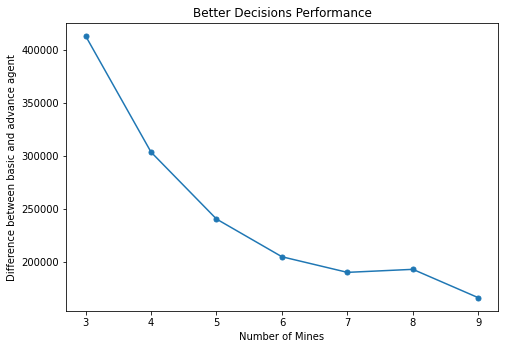

In [ ]:

xVals = [3,4,5,6,7,8,9]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(xVals, distArr, marker = ".", markersize=10)
ax.set_xlabel('Number of Mines')
ax.set_ylabel('Difference between basic and advance agent')
ax.set_title("Better Decisions Performance")
fig.show()

## 3. Advanced Agent

In [35]:
def sigmoid(omega, x):  #sigmoid function to return value between 0 and 255
  dotProduct = np.dot(omega,x)
  output = 1/(1+np.exp(-dotProduct))
  return 255*output 




In [36]:
#function to update weight vectors in stochastic gradient descent 
def advGradient(wr, wg, wb, x, y): #function takes in weight vectors, 3x3 gray scale patch, and rgb pixel
  alpha = 0.000001

  for i in range(len(x)):
    
    #preprocessing
    red = y[i][0]/255
    green = y[i][1]/255
    blue = y[i][2]/255

    x[i] = x[i]/255
    
    numerator1 = (-2 * x[i] * np.exp(-1 * wr[i] * x[i])) * (red * (1 + np.exp(-1 * wr[i] * x[i])) - 1)
    denominator1 = (1 + np.exp(-1 * wr[i] * x[i]))**3

    numerator2 = (-2 * x[i] * np.exp(-1 * wg[i] * x[i])) * (green * (1 + np.exp(-1 * wg[i] * x[i])) - 1)
    denominator2 = (1 + np.exp(-1 * wg[i] * x[i]))**3

    numerator3 = (-2 * x[i] * np.exp(-1 * wb[i] * x[i])) * (blue * (1 + np.exp(-1 * wb[i] * x[i])) - 1)
    denominator3 = (1 + np.exp(-1 * wb[i] * x[i]))**3

    wr[i] -= alpha * (numerator1/denominator1)
    wg[i] -= alpha * (numerator2/denominator2)
    wb[i] -= alpha * (numerator3/denominator3)

  return wr, wg, wb



In [37]:
#function to train left side of image and obtain weight vectors using stochastic gradient descent
def advTrain(greyS1, s1):  #function takes in left side of image in both gray scale and color and returns weight vectors
  wr = [0.00001, 0.00001,0.00002,0.00003,0.000004,0.00005,0.00004,0.000003,0.000002,0.000001]
  wg =  [0.0009, 0.000082, 0.000084, 0.000087, 0.000099, 0.000091, 0.000088, 0.000083, 0.000075, 0.000070]
  wb =  [0.0000003, 0.000025, 0.00004, 0.00003, 0.000045, 0.00005, 0.00006, 0.000070, 0.000060, 0.000055]

  movements = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(-1,-1),(-1,1),(1,-1)]
  
  for i in range(1,greyS1.shape[0]-1):
    for j in range(1,greyS1.shape[1]-1):
      #print("pixel: ", (i,j))
      gsArr = [greyS1[i][j]]
      colorArr = [s1[i][j]]
      for k in range(len(movements)):
        xVal = i + movements[k][0]
        yVal = j + movements[k][1]
        gsArr.append(greyS1[xVal][yVal])
        colorArr.append(s1[xVal][yVal])
        
    
    
    #print(gsArr)
      wr, wg, wb = advGradient(wr, wg, wb, gsArr, colorArr)
      #print(wr)
      #print(wg)

  return wr, wg, wb

In [38]:
wr, wg, wb = advTrain(greyS1, s1)
print(wr)
print(wg)
print(wb)


[0.00021902345834224463, 0.0002348134619871264, 0.00021306028055326532, 0.0002405105731344996, 0.00021239843734160367, 0.00027658130598526385, 0.00023270844383519373, 0.0001972855265792297, 0.00022589171049734548, 1e-06]
[0.001766724882875754, 0.000956292907798643, 0.0009440016230564762, 0.00095366639384502, 0.0009673732982832808, 0.0009649008860917822, 0.0009493381544164443, 0.0009422352695601247, 0.0009502229741924069, 7e-05]
[0.0012054497852815279, 0.001228773082869194, 0.0012462919279554916, 0.0012327648935427167, 0.0012528290617761896, 0.0012515458469169146, 0.001269162057485269, 0.0012737561025333124, 0.0012662790474661904, 5.5e-05]


In [39]:
#predicting color on right side of image (grayscale)

movements = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(-1,-1),(-1,1),(1,-1)]
s2Copy = s2.copy()
for i in range(1, greyS2.shape[0]-1):
  for j in range(1, greyS2.shape[1]-1):
    print("pixel: ", (i,j))
    gsArr = [1,greyS2[i][j]]
    for k in range(len(movements)):
        xVal = i + movements[k][0]
        yVal = j + movements[k][1]
        gsArr.append(greyS2[xVal][yVal])
    
    
    
    #predicting rgb values using weight vectors from before and the sigmoid function
    red = sigmoid(wr, gsArr) 
    green = sigmoid(wg, gsArr)
    blue = sigmoid(wb, gsArr)
  
    print((red,green,blue))
    s2Copy[i][j] = (red,green,blue)




Streaming output truncated to the last 5000 lines.
pixel:  (114, 56)
(151.90902498141205, 213.14154707292496, 227.90107493630862)
pixel:  (114, 57)
(151.63578284237548, 212.47785985949196, 227.29393873171702)
pixel:  (114, 58)
(151.04770614262807, 211.04310221449512, 225.97437165612092)
pixel:  (114, 59)
(150.63485770245933, 210.02801820689848, 225.02674000644444)
pixel:  (114, 60)
(150.4135153751159, 209.508486004037, 224.51328875514204)
pixel:  (114, 61)
(150.3513323378511, 209.30866093904376, 224.3154308580016)
pixel:  (114, 62)
(150.19894772961894, 208.74103832862207, 223.7831969452337)
pixel:  (114, 63)
(149.37017064646028, 206.56421845104646, 221.7106629534824)
pixel:  (114, 64)
(148.1592598899118, 203.31874191815737, 218.5566031317115)
pixel:  (114, 65)
(147.06884659467096, 200.34607616302395, 215.60797083196516)
pixel:  (114, 66)
(146.409965967548, 198.56820123987944, 213.8235948491844)
pixel:  (114, 67)
(146.02303502855958, 197.5480659767317, 212.78211604798474)
pixel:  (114, 

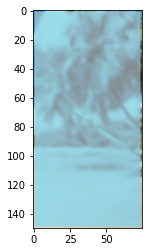

In [40]:
plt.imshow(s2Copy)

## 4. Bonus Advanced Agent

In [ ]:
#running SVC on all red pixels 
clf = svm.SVC(C = 1, decision_function_shape='ovo')

redVals = []
for i in range(s1.shape[0]):
  for j in range(s1.shape[1]):
    redVals.append(s1[i][j][0])

redVals = np.array(redVals)
redVals = redVals.reshape(-1,1)
reshapeGS = greyS1.reshape(-1,1)
print(redVals.shape)
reshapeGS.shape

clf.fit(reshapeGS, redVals)
#using model to predict red pixel values on right side
redResults = clf.predict(greyS2.reshape(-1,1))

(11250, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#running SVC on all green pixels 
clf = svm.SVC(C = 1, decision_function_shape='ovo')



greenVals = []
for i in range(s1.shape[0]):
  for j in range(s1.shape[1]):
    greenVals.append(s1[i][j][1])

greenVals = np.array(greenVals)
greenVals = greenVals.reshape(-1,1)
reshapeGS = greyS1.reshape(-1,1)


clf.fit(reshapeGS, greenVals)
#using model to predict green pixel values on right side
greenResults = clf.predict(greyS2.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(greenResults)

[139 139 139 ... 127 125 123]


In [ ]:
#running SVC on all blue pixels 
clf = svm.SVC(C = 1, decision_function_shape='ovo')


blueVals = []
for i in range(s1.shape[0]):
  for j in range(s1.shape[1]):
    blueVals.append(s1[i][j][2])

blueVals = np.array(blueVals)
blueVals = blueVals.reshape(-1,1)
reshapeGS = greyS1.reshape(-1,1)


clf.fit(reshapeGS, blueVals)
#using model to predict blue pixel values on right side
blueResults = clf.predict(greyS2.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(blueResults)

[226 222 226 ... 255 255 255]


[(3, 129, 226), (3, 129, 222), (3, 134, 226), (3, 129, 222), (3, 129, 222), (3, 129, 222), (3, 129, 222), (38, 155, 236), (216, 202, 177), (233, 234, 255), (233, 234, 255), (233, 234, 255), (229, 234, 255), (233, 234, 255), (233, 234, 255), (233, 234, 255), (233, 234, 255), (233, 234, 255), (233, 234, 255), (233, 234, 255), (229, 234, 255), (233, 234, 255), (114, 195, 244), (81, 184, 244), (20, 148, 233), (9, 141, 228), (2, 129, 222), (2, 109, 222), (213, 200, 255), (149, 198, 255), (91, 184, 244), (81, 174, 241), (11, 141, 230), (220, 207, 180), (114, 195, 255), (81, 174, 242), (81, 175, 242), (52, 169, 241), (52, 163, 238), (91, 184, 244), (114, 188, 244), (91, 184, 244), (91, 184, 244), (114, 195, 244), (216, 202, 177), (227, 212, 187), (220, 202, 177), (216, 200, 255), (149, 198, 255), (114, 193, 244), (66, 169, 241), (38, 152, 236), (38, 148, 233), (66, 169, 241), (81, 174, 242), (52, 163, 238), (52, 164, 241), (91, 184, 244), (81, 177, 242), (38, 152, 233), (20, 143, 232), (38, 1

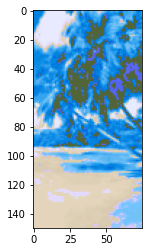

In [ ]:
resultS1 = []
for i in range(len(blueResults)):
  resultS1.append((redResults[i],greenResults[i],blueResults[i]))

print(resultS1)
resultS1 = np.array(resultS1)
resultS1 =resultS1.reshape(s1.shape)
resultS1.shape

plt.imshow(resultS1)

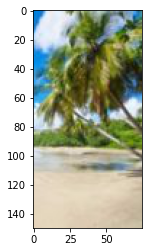

In [ ]:
plt.imshow(s2)

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496